In [1]:
import numpy as np
import pandas as pd
from tqdm import trange
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [28]:
class asset_allocation():
    def __init__(self, period, ALPHA=0.5, GAMMA=1, epsilon=0.1, u=0.1, d=-0.1, r=0.05, p=0.5, a=1, price=1, W0=10):
        self.ALPHA = ALPHA  # learning rate of Q-learning
        self.GAMMA = GAMMA # discount rate of Q-learning
        self.r = r # riskfree asset return
        self.price = price # stock price
        self.W0 = W0 # initial wealth
        self.actions = [0, 1]  # possible actions: 0: buy 0 unit of stocks, 1: buy 1 unit of stocks
        self.epsilon = epsilon
        self.up = 1 + u # the rising ratio of stock movement in binominal model
        self.down = 1 + d  # the falling ratio of stock movement in binominal model
        self.probability = p # the probability in binomial model
        self.period = period # time

    def this_action(self, state, time, q_value, epsilon=0.1):
        if np.random.binomial(1, epsilon) == 1:
            # exploration
            action = np.random.choice([0,1])
        else:
            # exploitation
            q_values = q_value[time, :]
            action = np.random.choice([action_ for action_, value_ in enumerate(q_values) if value_ == np.max(q_values)])
        return action

    def step(self, state, action, price):
        # get the next state, next price and reward
        move = np.random.binomial(1, self.probability)
        if move == 1:
            next_price = price * self.up
        else:
            next_price = price * self.down

        if action == 0:
            next_state = float(state) * (1 + self.r)
        else:
            next_state = (float(state) - price) * (1 + self.r) + next_price

        reward = next_state / float(state) - 1

        return str(next_state), next_price, reward

    def q_learning(self, q_value, epsilon):
        state = self.W0
        time = 0
        price = self.price

        while time < (self.period):
            action = self.this_action(state, time, q_value, epsilon)
            next_state, next_price, reward = self.step(state, action, price)

            if time < (self.period-1):
                q_value[time, action] += self.ALPHA * (
                    reward + self.GAMMA * np.max(q_value[time+1, :]) - q_value[time, action])

            else:
                q_value[time, action] += self.ALPHA * (reward + 0 - q_value[time, action])
            
            state = next_state
            price = next_price
            time += 1

        return q_value

    def train(self, epsilon, epoch=50000, plot_figure=False, time=9):

        q_value = np.zeros((self.period, len(self.actions)))

        action0 = []
        action1 = []
        
        for k in trange(epoch):
            if (k+1) % 1000 == 0:
                epsilon *= 0.8
            q_value = self.q_learning(q_value, epsilon)
            action0.append(q_value[time,0])
            action1.append(q_value[time,1])

        self.q_value = q_value
        
        if plot_figure:
            plt.plot(action0, c = 'red', label = 'action0')
            plt.plot(action1,  c = 'blue', label = 'action1')
            plt.legend(loc='lower right')
            plt.title('q_value at time %s of two actions'%(time))
            plt.show()
        return

    def get_q_value(self):
        return self.q_value
    
    def print_q_table(self):
        q_table = pd.DataFrame(self.q_value, columns=['0','1'])
        print(q_table)
        return
    
    def print_optimal_policy(self):
        q_value = self.q_value
        optimal_policy = []
        for i in range(self.period):
            bestAction = np.argmax(q_value[i, :])
            if ~np.any(q_value[i, :]):
                optimal_policy.append('')
            elif bestAction == 0:
                optimal_policy.append(0)
            elif bestAction == 1:
                optimal_policy.append(1)
        print(optimal_policy)
        return

100%|███████████████████████████████████| 50000/50000 [00:07<00:00, 6845.39it/s]


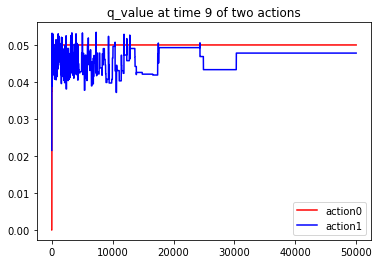

      0         1
0  0.50  0.498309
1  0.45  0.442390
2  0.40  0.396887
3  0.35  0.345483
4  0.30  0.286650
5  0.25  0.243406
6  0.20  0.196454
7  0.15  0.143172
8  0.10  0.094542
9  0.05  0.047802
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
if __name__ == '__main__':
    solver = asset_allocation(period=10)
    solver.train(epsilon=0.1, plot_figure=True)
    solver.print_q_table()
    solver.print_optimal_policy()


100%|███████████████████████████████████| 50000/50000 [00:07<00:00, 6730.07it/s]


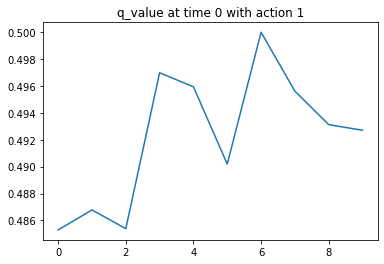

The mean of q-value is 0.4922 and standard variance is 0.0049


In [42]:
q_values = []
for i in range(10):
    solver = asset_allocation(period=10)
    solver.train(epsilon=0.1)
    q_value = solver.get_q_value()
    q_values.append(q_value[0,1])

plt.plot(q_values)
plt.title('q_value at time 0 with action 1')
plt.show()
print('The mean of q-value is %0.4f and standard variance is %0.4f'%(np.mean(q_values),np.std(q_values)))